In [47]:
# Load the tfa model 
from pytfa.io.json import load_json_model
model_file = 'reduced_model_ETC_core_20240816-155234_continuous.json'
tmodel = load_json_model(model_file)
#sol = tmodel.optimize()

2024-09-13 10:40:40,077 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [48]:
# Reload and prepare the model
from skimpy.io.yaml import load_yaml_model
from skimpy.utils.tabdict import TabDict

kmodel = load_yaml_model(model_file.replace("_continuous.json", "_kinetic_curated.yml"))

# We calculate control coeffcients with respect
#  to enzyme activity and boundary concentrations
parameter_list = TabDict([(k, p.symbol) for k, p in kmodel.parameters.items() if p.name.startswith('vmax_forward')])
boundary_parameters = TabDict([(c.reactant.name, c.reactant.symbol) for c in kmodel.boundary_conditions.values()])
parameter_list.update(boundary_parameters)

# Compile the jacobian expressions
NCPU = 12
kmodel.prepare()
kmodel.compile_mca(ncpu=NCPU, parameter_list=parameter_list)

In [49]:
# Load TFA samples 
import pandas as pd
tfa_sample_file = 'reduced_model_ETC_core_20240816-155234_tfa_sampling.csv'
tfa_samples = pd.read_csv(tfa_sample_file)

In [50]:
# Get  differences to the mean of tfa_tables 
 
(tfa_samples.iloc[75] - tfa_samples.mean()).abs().sort_values(ascending=False).head(10)

LC_glu_L_c       1.046142
LC_oaa_c         0.945731
LC_coa_c         0.823466
DG_ASPGLUm       0.707956
DG_MDH           0.665851
DG_FACOAL160i    0.646043
LC_glc_D_c       0.583636
DG_FAOXC160      0.488572
LC_glyc3p_c      0.487140
LC_aacoa_m       0.439192
dtype: float64

In [51]:
# Load parameter samples 
from skimpy.core.parameters import load_parameter_population
parameter_population = load_parameter_population(tfa_sample_file.replace(".csv",'_pruned_parameters.hdf5'))

In [52]:
# Scaling parameters
CONCENTRATION_SCALING = 1e3 # 1 mol to 1 umol
TIME_SCALING = 1 # 1min
DENSITY = 1200 # g/L 
GDW_GWW_RATIO = 1.0 # Fluxes are in gWW

In [53]:
# Parameter selection 
from skimpy.analysis.oracle.load_pytfa_solution import load_fluxes, load_concentrations,\
    load_equilibrium_constants
import numpy as np

EPSILON = 1e-3

flux_controll_coefficients = []
parameter_sample_ids = []

for k in parameter_population._index:

    parameter_values = parameter_population[k]

    i = int(k.split(',')[0]) 
    ref_solution = tfa_samples.loc[i]


    # Load fluxes and concentrations
    fluxes = load_fluxes(ref_solution, tmodel, kmodel,
                            density=DENSITY,
                            ratio_gdw_gww=GDW_GWW_RATIO,
                            concentration_scaling=CONCENTRATION_SCALING,
                            time_scaling=TIME_SCALING)
    
    concentrations = load_concentrations(ref_solution, tmodel, kmodel,
                                            concentration_scaling=CONCENTRATION_SCALING)
    
    this_fc = kmodel.flux_control_fun(fluxes,concentrations,[parameter_values, ])

    # Prune for positive substrate control
    medium_control = this_fc.slice_by('sample', 0).loc[['L_LACt2r','GLCt1r', 'FATP1t', 'BHBt'],
                                                       ['lac_L_e', 'glc_D_e', 'hdca_e', 'bhb_e']]
    diag_is_positive = np.all(np.diag(medium_control.values) > 0)

    if diag_is_positive:
        flux_controll_coefficients.append(this_fc)
        parameter_sample_ids.append(k)


In [54]:
# Make a pruned parameter population
from skimpy.core.parameters import ParameterValuePopulation
parameter_population_pruned = [parameter_population[k] for k in parameter_sample_ids]
parameter_population_pruned = ParameterValuePopulation(parameter_population_pruned, kmodel=kmodel, index=parameter_sample_ids)

In [55]:
# Stack the results
from skimpy.utils.tensor import Tensor
import numpy as np
# Concat the data
data = np.concatenate([f._data for f in flux_controll_coefficients], axis=2)
# Conver to tensor 
indexes = flux_controll_coefficients[0].indexes['flux'], flux_controll_coefficients[0].indexes['parameter'], pd.Index(parameter_sample_ids, name='samples')
control_coefficients = Tensor(data, indexes )


In [56]:
print(f"{len(parameter_sample_ids)} models selectet which is  {len(parameter_sample_ids) / len( parameter_population._data) * 100:.1f}% of all the models")

295 models selectet which is  99.7% of all the models


In [57]:
# Prepare the model to run an ODE simulaiton
kmodel.compile_ode(ncpu=NCPU)

In [58]:
# Build function to compute fluxes from concentrations
from skimpy.analysis.ode.utils import make_flux_fun
from skimpy.utils.namespace import QSSA

flux_function = make_flux_fun(kmodel, QSSA)

In [59]:
from skimpy.core.parameters import ParameterValues
from tqdm import tqdm

# Function for population analysis

def steady_state_perturbation(parameter, range=np.logspace(-1,1,51,base=2) , 
                            additional_parameter_changes={},
                            time = [0,2], # 1uhr to 10hr
                            parameter_population=parameter_population_pruned, 
                            kmodel=kmodel, 
                            flux_function=flux_function,
                            tfa_samples=tfa_samples, 
                            end_ix=-1
                            ):
    
    # List of dataframes
    results = []

    # Run the perturbation for each parameterset
    parameter_population_index = list(parameter_population._index.keys())
    for parameter_set_id in tqdm(parameter_population_index[:end_ix]):

        # This will be a list of dataframes
        this_results = []

        thermo_index = int(parameter_set_id.split(',')[0])
        thermo_sample = tfa_samples.loc[thermo_index]

        concentrations = load_concentrations(thermo_sample, tmodel, kmodel, 
                                            concentration_scaling=CONCENTRATION_SCALING)

        for k in kmodel.initial_conditions:
                kmodel.initial_conditions[k] = concentrations[k]

        # Load the parameter values 
        kmodel.parameters = parameter_population[parameter_set_id]

        # Integrate additional parameters changes (fold changes)
        for k, v in additional_parameter_changes.items():
            kmodel.parameters[k].value = kmodel.parameters[k].value * v

        # Perturb the main parameter
        p0 = kmodel.parameters[parameter].value
        
        for perturbation_value in range:
            kmodel.parameters[parameter].value = perturbation_value * p0
            # Dynamic solution            
            sol = kmodel.solve_ode(time, solver_type='cvode' , max_steps=1e9, rtol=1e-6)
            # Get steady state concentrations
            steady_state_concentrations = sol.concentrations.iloc[-1]

            # Compute the fluxes at steady state
            # Get parameters value set 
            parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
            parameter_values = ParameterValues(parameter_values, kmodel)

            steady_state_fluxes = pd.Series(flux_function(steady_state_concentrations, parameters=parameter_values), 
                                            index=kmodel.reactions.keys())
            
            # Add the results to a dataframe 
            steady_state_output = pd.concat([steady_state_concentrations, steady_state_fluxes])
            # Add metadata 
            steady_state_output['pertubration'] = perturbation_value
            steady_state_output['parameter_set'] = parameter_set_id
            steady_state_output['parameter'] = parameter    
            steady_state_output['aditional_parameters'] = [f'{k}:{v:.1f}' for k,v in additional_parameter_changes.items()]

            this_results.append(steady_state_output)

        # Concatenate the results
        this_results = pd.concat(this_results, axis=1).T
        results.append(this_results)

    # Concatenate the results
    results = pd.concat(results)
    return results


In [60]:
# # Compute perturbations for each fuel concentration
# parameters = ['lac_L_e', 'glc_D_e', 'hdca_e', 'bhb_e']
# results = [steady_state_perturbation(p, end_ix=50) for p in parameters]
# results = pd.concat(results)

In [61]:
# # Save the results
# name = model_file.replace('.json', '')
# results.to_csv(f'output/{name}_steady_state_perturbation.csv')

In [62]:
uptake_fluxes = ['L_LACt2r','GLCt1r', 'FATP1t', 'BHBt']

In [63]:
# import matplotlib.pyplot as plt
# import seaborn as sns 
# # Plot the results as line plot 
# sns.lineplot(data=results, x='pertubration', y='cyt_atp2adp', hue='parameter')
# plt.xscale('log', base=2)


In [64]:
# Robusteness analysis for each regulation parmeter 

activation_parameters = [str(p.symbol) for p in kmodel.parameters.values() if 'activation' in str(p.name)]
inhibition_parameters = [str(p.symbol) for p in kmodel.parameters.values() if 'inhibition' in str(p.symbol)]

regulation_parameters = [None, ] + activation_parameters + inhibition_parameters

basic_arameters = [ 'glc_D_e', 'lac_L_e', 'bhb_e','hdca_e',]

# Robustness analysis for each regulation parmeter
robustness_results = []

# Compute perturbations for each fuel concentration
for r in regulation_parameters:
    if r is None:
        aditional_parameter_changes = {}
    else:
        aditional_parameter_changes = {r:1e2}
    
    results = [steady_state_perturbation(p, range=[0.5, 1, 2.0], end_ix=50,
                                         additional_parameter_changes=aditional_parameter_changes) for p in basic_arameters] 
    results = pd.concat(results)

    robustness_results.append(results)


# Contact the results
name = model_file.replace('.json', '')
robustness_results = pd.concat(robustness_results)
robustness_results.to_csv(f'output/{name}_robustness_analysis.csv')

  0%|          | 0/50 [00:00<?, ?it/s]

 60%|██████    | 30/50 [00:12<00:08,  2.36it/s]


KeyboardInterrupt: 

In [ ]:
# Robusteness with respect to energy production
name = model_file.replace('.json', '')

robustness_results = pd.read_csv(f'output/{name}_robustness_analysis.csv')

# Clean up the the aditional parameter column
# remove []
robustness_results['aditional_parameters'] = robustness_results['aditional_parameters'].apply(lambda x: x[1:-1])
# Remove quotes
robustness_results['aditional_parameters'] = robustness_results['aditional_parameters'].apply(lambda x: x.replace("'", ""))
# Remove spaces
robustness_results['aditional_parameters'] = robustness_results['aditional_parameters'].apply(lambda x: x.replace(" ", ""))
# Remove :100 
robustness_results['aditional_parameters'] = robustness_results['aditional_parameters'].apply(lambda x: x.replace(":100.0", ""))

pivoted_robustness_results = robustness_results.pivot_table(index=['parameter_set', 'parameter', 'aditional_parameters'], columns='pertubration', values='cyt_atp2adp').reset_index()

In [ ]:
pivoted_robustness_results

pertubration,parameter_set,parameter,aditional_parameters,0.5,1.0,2.0
0,"1,0",bhb_e,,7215.597011,7215.597468,7215.598167
1,"1,0",bhb_e,k_activation_AM_adp_c_PFK,7215.595273,7215.595676,7215.596297
2,"1,0",bhb_e,k_activation_AM_adp_c_PYK,7215.578081,7215.580088,7215.582814
3,"1,0",bhb_e,k_activation_AM_adp_m_CSm,7215.597255,7215.597718,7215.598427
4,"1,0",bhb_e,k_activation_AM_adp_m_ICDHxm,142.181987,143.235494,145.224884
...,...,...,...,...,...,...
515,"1,5",lac_L_e,k_inhibition_IM_nadh_m_AKGDm,7215.649724,7215.598820,7215.423830
516,"1,5",lac_L_e,k_inhibition_IM_nadh_m_CSm,7215.649522,7215.596939,7215.418336
517,"1,5",lac_L_e,k_inhibition_IM_nadh_m_PDHm,7215.653427,7215.601494,7215.432268
518,"1,5",lac_L_e,k_inhibition_IM_pmtcoa_c_LDH_L,7215.645595,7215.591419,7215.411747


In [ ]:
# Normalize by the reference flux of parameter_set , parameters and aditional_parameters == ""
cols = [0.5,1.0, 2.0]
normalized_by_reference_parameters = pivoted_robustness_results.groupby(['parameter_set', 'parameter'])[cols].transform(lambda x: x / x.iloc[0])
normalized_by_fold_change = pivoted_robustness_results[cols].div(pivoted_robustness_results[1.0], axis=0)


In [ ]:
pivoted_robustness_results[cols] = normalized_by_fold_change * normalized_by_reference_parameters

In [ ]:
# Count for eacher parameter and aditional parameter the number of times the flux is different from 1.0
# Use the 0.5 and 2.0 perturbations

# groupby parameter and aditional parameter
grouped = pivoted_robustness_results.groupby(['parameter', 'aditional_parameters'])

# Count the number of times the flux is different from 1.0 in the 0.5 and 2.0 columns
counted = grouped[[0.5,2.0]].apply(lambda x: (x <= 0.9).sum() + (x >= 1.1).sum()).reset_index()


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_13568/1937049157.py:32: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (group, data) in enumerate(counted.groupby(['aditional_parameters'])):
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_13568/1937049157.py:37: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (group, data) in enumerate(counted.groupby(['parameter'])):


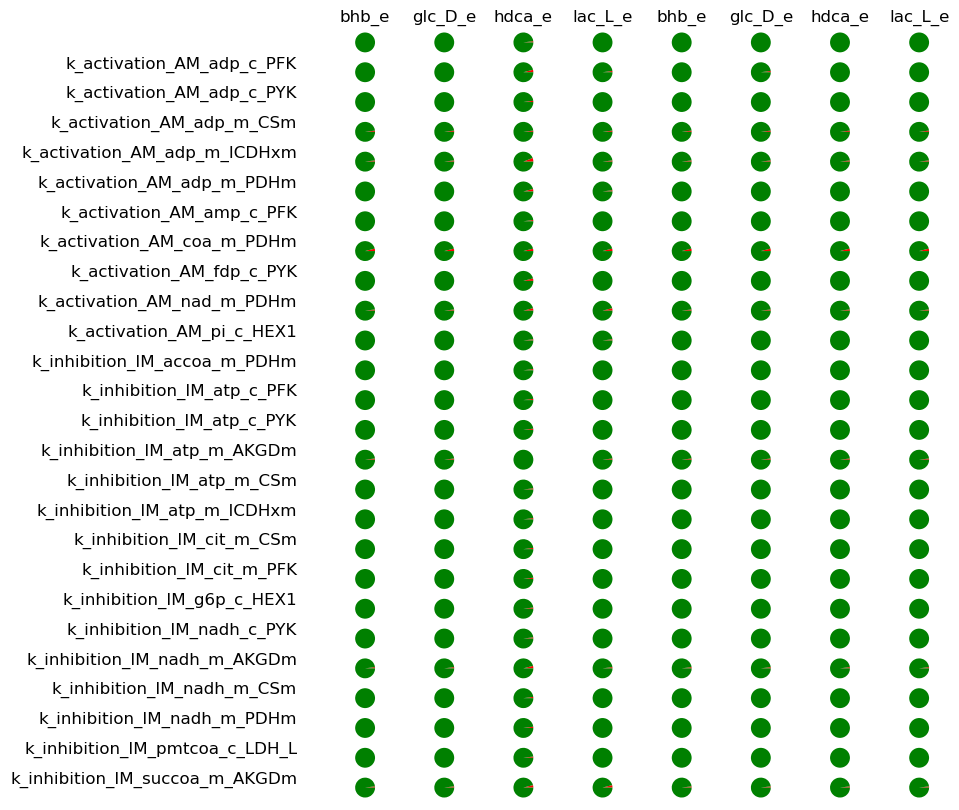

In [ ]:
# Plot the counts on grd of pie charts

import matplotlib.pyplot as plt
import seaborn as sns

# Make a pichart for each parameter, aditional parameter pair
n_x = len(counted['parameter'].unique())
n_y = len(counted['aditional_parameters'].unique())
fig, axes = plt.subplots(n_y, 2*n_x, figsize=(8,10))

# Iterate over the groups
n_total = 50 


for i, (group, data) in enumerate(counted.groupby(['parameter', 'aditional_parameters'])):
    # Plot the charts for the reductions 
    # Rows are aditional parameters and columns are parameters
    ax = axes[i%n_y, i//n_y]
    sensitive = data[0.5].values[0]
    insensitive = n_total - sensitive
    # Make the pie chart with counts
    ax.pie([sensitive, insensitive], colors=['red', 'green'], )
    # Plot the charts for the increases
    ax = axes[i%n_y, i//n_y + n_x]
    sensitive = data[2.0].values[0]
    insensitive = n_total - sensitive
    # Make the pie chart with counts
    ax.pie([sensitive, insensitive], colors=['red', 'green'], )


# Label each row with the aditional_parameters name horizontally
for i, (group, data) in enumerate(counted.groupby(['aditional_parameters'])):
    axes[i, 0].set_ylabel(group, rotation=0, labelpad=40, fontsize=12, ha='right', va='center')
    axes[i, 0].yaxis.set_label_position("left")
    
# Label each column with the parameter name vertically
for i, (group, data) in enumerate(counted.groupby(['parameter'])):
    axes[0, i].set_title(group, fontsize=12)
    axes[0, i].xaxis.set_label_position("top")
    axes[0, i].xaxis.set_ticks_position("top")
    axes[0, i].xaxis.set_label_coords(0.5, 1.2)
    axes[0, i].xaxis.set_tick_params(labelsize=12)

    axes[0, i+n_x].set_title(group, fontsize=12)
    axes[0, i+n_x].xaxis.set_label_position("top")
    axes[0, i+n_x].xaxis.set_ticks_position("top")
    axes[0, i+n_x].xaxis.set_label_coords(0.5, 1.2)
    axes[0, i+n_x].xaxis.set_tick_params(labelsize=12)





In [ ]:
counted

pertubration,parameter,aditional_parameters,0.5,2.0
0,bhb_e,,0,0
1,bhb_e,k_activation_AM_adp_c_PFK,0,0
2,bhb_e,k_activation_AM_adp_c_PYK,0,0
3,bhb_e,k_activation_AM_adp_m_CSm,1,1
4,bhb_e,k_activation_AM_adp_m_ICDHxm,1,1
...,...,...,...,...
99,lac_L_e,k_inhibition_IM_nadh_m_AKGDm,1,1
100,lac_L_e,k_inhibition_IM_nadh_m_CSm,0,0
101,lac_L_e,k_inhibition_IM_nadh_m_PDHm,0,0
102,lac_L_e,k_inhibition_IM_pmtcoa_c_LDH_L,0,0
